<a href="https://colab.research.google.com/github/JRCon1/Technical-Analysis-Project/blob/main/RSI_EMA_SMA_Plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
%%capture

# Use Capture to Hide output of Package Download

!pip install ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
from ta.momentum import RSIIndicator
from ta.trend import MACD, EMAIndicator, SMAIndicator

In [49]:
# The file is attached in the repository, or use the data download in the next codeblock instead.
df = pd.read_csv('/content/HistoricalData_1740111227348.csv').set_index('Date')

# Set the Date as Index
df.index = pd.to_datetime(df.index)

# Sort values properly
df = df.sort_index(ascending=True)
df = df[['Close/Last', 'Volume']]
df['Close/Last'] = df['Close/Last'].str.replace('$', '')
df['Close/Last'] = df['Close/Last'].astype(float)

price = df['Close/Last'] # Stock Prices

In [51]:
# OPTIONAL BLOCK IF YOU DO NOT HAVE YOUR OWN PRICE

#    ticker = 'AAPL' # Replace with Ticker of Choice

#    import yfinance as yf
#    df = yf.download(ticker, start = '2025-2-20')['Close'] # Pulls Adjusted Close Data if Stock Prices are not already on hand
#    price = df['Close']

In [52]:
# Define 7, 14, 21, and 60 day RSI, EMA, and SMA values.
RSI_7 = RSIIndicator(price, window=7).rsi()
RSI_14 = RSIIndicator(price, window=14).rsi()
RSI_21 = RSIIndicator(price, window=21).rsi()
RSI_60 = RSIIndicator(price, window=60).rsi()

EMA_7 = EMAIndicator(price, window=7).ema_indicator()
EMA_14 = EMAIndicator(price, window=14).ema_indicator()
EMA_21 = EMAIndicator(price, window=21).ema_indicator()
EMA_60 = EMAIndicator(price, window=60).ema_indicator()

SMA_7 = SMAIndicator(price, window=7).sma_indicator()
SMA_14 = SMAIndicator(price, window=14).sma_indicator()
SMA_21 = SMAIndicator(price, window=21).sma_indicator()
SMA_60 = SMAIndicator(price, window=60).sma_indicator()

In [53]:
# Function takes in your investment size (initial_capital), the asset prices (price), the indicator used (indicator & also defined above),
# the specific type of indcator (indicator_type | 'RSI', 'EMA', or 'SMA'), and lastly the buy and sell level if you're using RSI (buy_level & sell_level)

def backtest_indicator(initial_capital, price, indicator, indicator_type="RSI", buy_level=30, sell_level=70):
    capital = initial_capital
    shares = 0
    in_position = False

    # Start at 1 so we can compare to the previous time step (for crossovers)
    for i in range(1, len(price)):
        current_price = price.iloc[i]
        current_indicator = indicator.iloc[i]
        previous_price = price.iloc[i-1]
        previous_indicator = indicator.iloc[i-1]

        # Skip if indicator data is missing
        if np.isnan(current_indicator) or np.isnan(previous_indicator):
            continue

        if indicator_type.upper() == "RSI":
            # Buy when RSI drops below the buy_level and we're not in a position
            if not in_position and current_indicator < buy_level:
                shares_to_buy = int(capital // current_price)
                if shares_to_buy > 0:
                    capital -= shares_to_buy * current_price
                    shares += shares_to_buy
                    in_position = True
                    print(f"RSI: Bought {shares_to_buy} shares at ${current_price:.2f} (RSI: {current_indicator:.2f})")
            # Sell when RSI goes above the sell_level and we are in a position
            elif in_position and current_indicator > sell_level:
                capital += shares * current_price
                print(f"RSI: Sold {shares} shares at ${current_price:.2f} (RSI: {current_indicator:.2f})")
                shares = 0
                in_position = False

        elif indicator_type.upper() in ["EMA", "SMA"]:
            # Crossover strategy: check if price crosses the indicator
            # Buy when price crosses above the moving average
            if not in_position and (previous_price < previous_indicator and current_price >= current_indicator):
                shares_to_buy = int(capital // current_price)
                if shares_to_buy > 0:
                    capital -= shares_to_buy * current_price
                    shares += shares_to_buy
                    in_position = True
                    print(f"{indicator_type.upper()}: Bought {shares_to_buy} shares at ${current_price:.2f} (price crossed above {indicator_type.upper()})")
            # Sell when price crosses below the moving average
            elif in_position and (previous_price > previous_indicator and current_price <= current_indicator):
                capital += shares * current_price
                print(f"{indicator_type.upper()}: Sold {shares} shares at ${current_price:.2f} (price crossed below {indicator_type.upper()})")
                shares = 0
                in_position = False

    # If still holding shares at the end, value them at the last price
    final_value = capital + shares * price.iloc[-1]
    print(f"Final portfolio value using {indicator_type.upper()} strategy: {final_value}")
    print("Remaining shares:", shares)
    return final_value, shares

# Backtest examples:

print("=== RSI 7-day Strategy ===")
backtest_indicator(10_000, price, RSI_7, indicator_type="RSI", buy_level=30, sell_level=70)

print("\n=== EMA 7-day Strategy ===")
backtest_indicator(10_000, price, EMA_7, indicator_type="EMA")

print("\n=== SMA 7-day Strategy ===")
backtest_indicator(10_000, price, SMA_7, indicator_type="SMA")


=== RSI 7-day Strategy ===
RSI: Bought 5 shares at $175.10 (RSI: 17.43)
RSI: Sold 5 shares at $183.38 (RSI: 77.92)
RSI: Bought 4 shares at $209.27 (RSI: 25.34)
RSI: Sold 4 shares at $226.05 (RSI: 71.17)
RSI: Bought 5 shares at $216.32 (RSI: 27.00)
RSI: Sold 5 shares at $233.00 (RSI: 74.79)
RSI: Bought 5 shares at $222.91 (RSI: 26.06)
RSI: Sold 5 shares at $232.87 (RSI: 71.16)
RSI: Bought 5 shares at $236.85 (RSI: 23.15)
RSI: Sold 5 shares at $244.60 (RSI: 72.05)
Final portfolio value using RSI strategy: 1280.47
Remaining shares: 0

=== EMA 7-day Strategy ===
EMA: Bought 5 shares at $173.23 (price crossed above EMA)
EMA: Sold 5 shares at $171.13 (price crossed below EMA)
EMA: Bought 5 shares at $173.00 (price crossed above EMA)
EMA: Sold 5 shares at $172.62 (price crossed below EMA)
EMA: Bought 5 shares at $173.72 (price crossed above EMA)
EMA: Sold 5 shares at $171.37 (price crossed below EMA)
EMA: Bought 5 shares at $173.31 (price crossed above EMA)
EMA: Sold 5 shares at $171.48 (pric

(1160.1999999999998, 4)

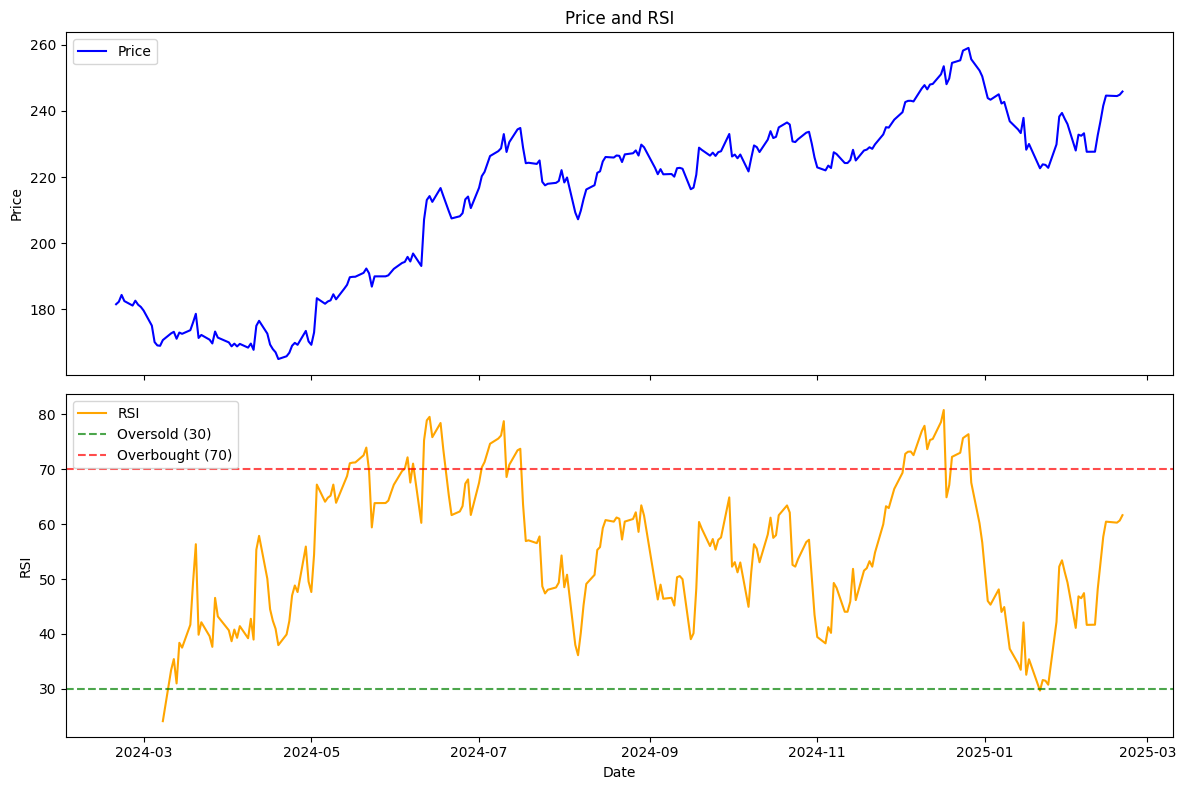

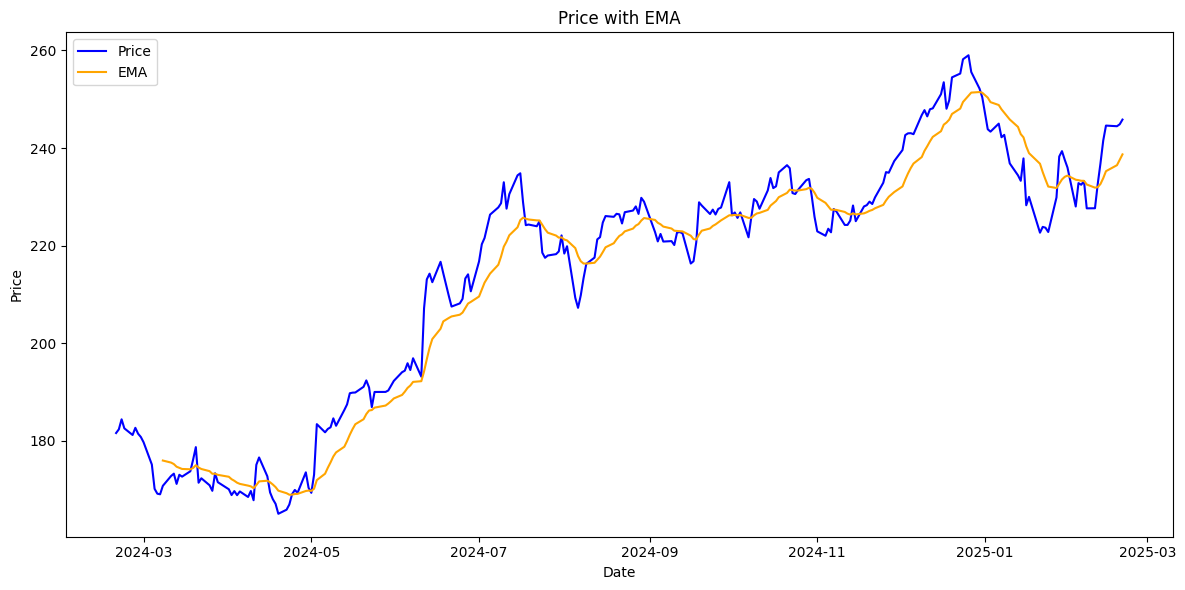

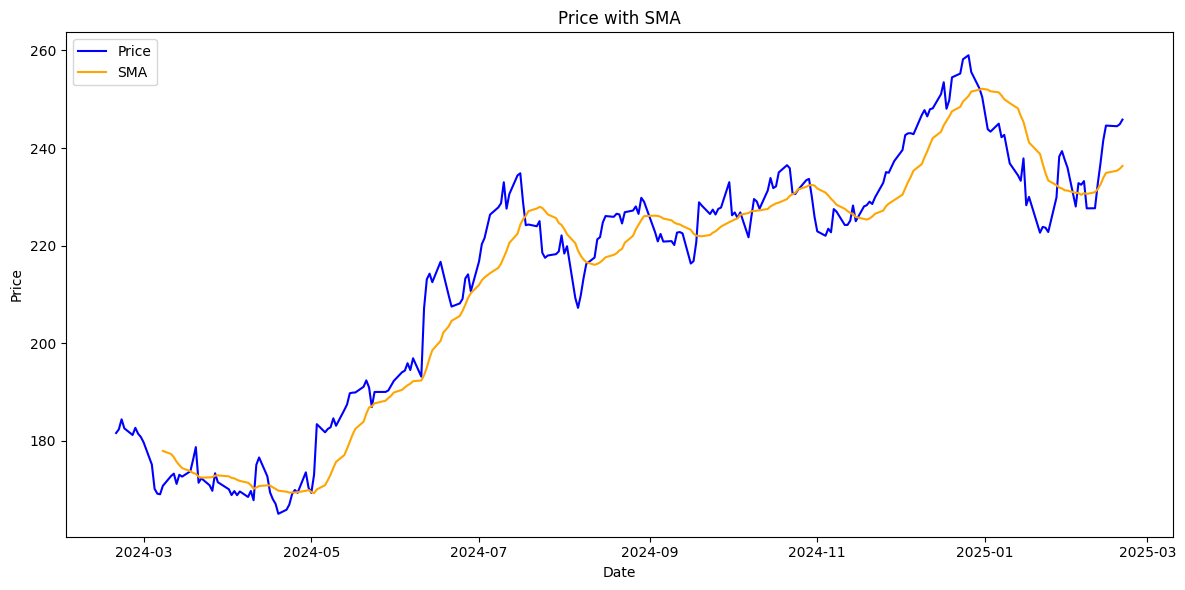

In [55]:
# Define the plotting function that takes in the asset prices (price), the indicator (defined two cells above as 'indicator'), and the indicator as a string (indicator_type | 'RSI', 'SMA', 'EMA')

def plot_indicator(price, indicator, indicator_type="RSI"):
    if indicator_type.upper() == "RSI":
        # Two subplots: Price and RSI
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        ax1.plot(price.index, price, label='Price', color='blue')
        ax1.set_ylabel('Price')
        ax1.set_title('Price and RSI')
        ax1.legend(loc='upper left')
        ax2.plot(indicator.index, indicator, label='RSI', color='orange')
        ax2.axhline(30, linestyle='--', color='green', alpha=0.7, label='Oversold (30)')
        ax2.axhline(70, linestyle='--', color='red', alpha=0.7, label='Overbought (70)')
        ax2.set_ylabel('RSI')
        ax2.set_xlabel('Date')
        ax2.legend(loc='upper left')
        plt.tight_layout()
    elif indicator_type.upper() in ["EMA", "SMA"]:
        # Plot price and overlay the moving average
        plt.figure(figsize=(12, 6))
        plt.plot(price.index, price, label='Price', color='blue')
        plt.plot(indicator.index, indicator, label=indicator_type.upper(), color='orange')
        plt.title(f"Price with {indicator_type.upper()}")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend(loc='upper left')
        plt.tight_layout()
    plt.show()

# Example plots:
plot_indicator(price, RSI_14, indicator_type="RSI")
plot_indicator(price, EMA_14, indicator_type="EMA")
plot_indicator(price, SMA_14, indicator_type="SMA")